In [4]:
import os

# Move the uploaded API key to the correct directory
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle (1).json", "/root/.kaggle/kaggle.json")

# Set file permissions for the API key
os.chmod("/root/.kaggle/kaggle.json", 600)

In [5]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
 98% 97.0M/98.7M [00:07<00:00, 17.6MB/s]
100% 98.7M/98.7M [00:07<00:00, 14.6MB/s]


In [6]:
!unzip melanoma-skin-cancer-dataset-of-10000-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: melanoma_cancer_dataset/train/benign/melanoma_643.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_644.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_645.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_646.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_647.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_648.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_649.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_65.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_650.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_651.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_652.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_653.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_654.jpg  
  inflating: melanoma_cancer_dataset/train/benign/mel

## Importing Libraries

In [7]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input, GlobalAveragePooling2D

from keras.layers import Activation, Dropout,  Flatten, Dense,MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
data_path='/content/melanoma_cancer_dataset'
train_data_path='/content/melanoma_cancer_dataset/train'
test_data_path='/content/melanoma_cancer_dataset/test'

## Analying the DataSet

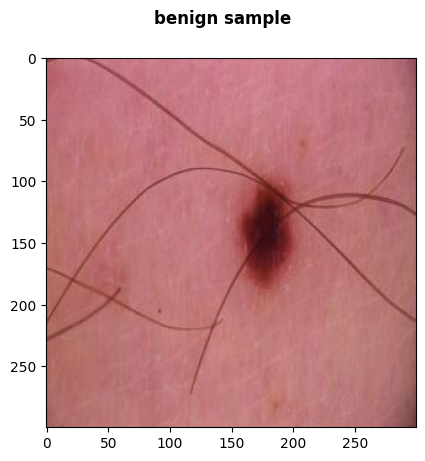

In [9]:
benign_sample = imread(train_data_path+"/benign"+"/melanoma_2898.jpg")
plt.imshow(benign_sample)
plt.suptitle('benign sample', fontsize=12, weight='bold')

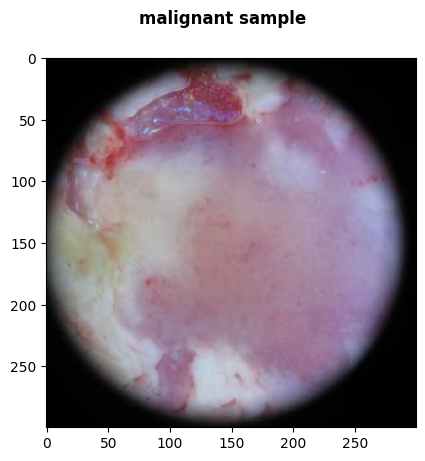

In [10]:
benign_sample = imread(train_data_path+"/malignant"+"/melanoma_5708.jpg")
plt.imshow(benign_sample)
plt.suptitle('malignant sample', fontsize=12, weight='bold');

In [11]:
# Data shape
print("Shape of image is -",cv2.imread(train_data_path+"/malignant"+"/melanoma_5708.jpg").shape)

Shape of image is - (300, 300, 3)


## Data Preprocessing

In [12]:
def data_preprocessing(output_size):
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                    zoom_range = 0.2,
                                    shear_range = 0.2,
                                    rotation_range=15,
                                    fill_mode='nearest',
                                    horizontal_flip = True)

  test_datagen = ImageDataGenerator(rescale = 1./255)

  training_set = train_datagen.flow_from_directory(train_data_path,
                                                  target_size = (output_size, output_size),
                                                  batch_size = 32,
                                                  class_mode = 'binary',
                                                  shuffle=True)

  test_set = test_datagen.flow_from_directory(test_data_path,
                                              target_size = (output_size, output_size),
                                              batch_size = 32,
                                              class_mode = 'binary',
                                              shuffle = False)

  return training_set, test_set

## Building Generalize Model

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,ResNet50, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, concatenate

def model(input_size, model):
  # Load pre-trained EfficientNet and ResNet models
  efficientnet_model = model(weights='imagenet', include_top=False, input_shape=(input_size,input_size, 3))
  vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_size, input_size, 3))

  # Freeze the layers in both models
  for layer in efficientnet_model.layers:
      layer.trainable = False

  for layer in vgg_model.layers:
      layer.trainable = False

  # Define input layer
  input_layer = Input(shape=(input_size, input_size, 3))

  # Get the output tensors of the two models
  efficientnet_output = efficientnet_model(input_layer)
  vgg_output = vgg_model(input_layer)

  # Global average pooling for each model's output
  efficientnet_output = GlobalAveragePooling2D()(efficientnet_output)
  vgg_output = GlobalAveragePooling2D()(vgg_output)

  # Concatenate the outputs
  combined_output = concatenate([efficientnet_output, vgg_output])

  # Dense layers for classification
  x = Dense(256, activation='relu')(combined_output)
  x = Dropout(0.5)(x)
  output_layer = Dense(1, activation='sigmoid')(x)

  # Create the ensemble model
  ensemble_model = Model(inputs=input_layer, outputs=output_layer)

  # Compile the model
  ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Display the model summary
  ensemble_model.summary()

  return ensemble_model

## Testing Different Model

In [ ]:
# EfficientNetB0
training_set,test_set = data_preprocessing(output_size=224)
ensemble = model(input_size=224,model=EfficientNetB0)
ensemble.fit(training_set, validation_data=test_set, epochs=5)

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 7, 7, 1280)           4049571   ['input_18[0][0]']            
 )                                                                                                
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_18[0][0]']            
                                          

In [ ]:
# EfficientNetB1
training_set,test_set = data_preprocessing(output_size=240)
ensemble1 = model(input_size=240,model=EfficientNetB1)
history = ensemble1.fit(training_set, validation_data=test_set, epochs=5)

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 efficientnetb1 (Functional  (None, 8, 8, 1280)           6575239   ['input_21[0][0]']            
 )                                                                                                
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_21[0][0]']            
                                                          8                                       
        

In [ ]:
# EfficientNetB2
training_set,test_set = data_preprocessing(output_size=260)
ensemble2 = model(input_size=260,model=EfficientNetB2)
ensemble2.fit(training_set, validation_data=test_set, epochs=10)

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
31790344/31790344 [==============================] - 0s 0us/step
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 260, 260, 3)]        0         []                            
                                                                                                  
 efficientnetb2 (Functional  (None, 9, 9, 1408)           7768569   ['input_24[0][0]']            
 )                                                                                                
                                                                                                  
 vgg16 (Functional)          (None, 8, 8, 512)            1471468   ['input_24[0][0]']            
                                          

In [ ]:
# EfficientNetB3
training_set,test_set = data_preprocessing(output_size=300)
ensemble3 = model(input_size=300,model=EfficientNetB3)
history = ensemble3.fit(training_set, validation_data=test_set, epochs=10)

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 efficientnetb3 (Functional  (None, 10, 10, 1536)         1078353   ['input_3[0][0]']             
 )                                                        5                                       
                                                                                                  
 vgg16 (Functional)          (None, 9, 9, 512)            1471468   ['input_3[0][0]']             
                                            

## Final Model Training

In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Define the file path for saving the model
checkpoint_path = "efficientnet_b3_checkpoint.h5"

# Define the callback to save the model at each epoch
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=False,  # Save the entire model
                                      save_best_only=True,     # Save only the best model
                                      monitor='val_loss',      # Monitor validation loss
                                      mode='min',              # Minimize the validation loss
                                      verbose=1)

# Define the TensorBoard callback
log_dir = "logs/efficientnet_b3"  # Directory for storing TensorBoard logs
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Load the data
training_set, test_set = data_preprocessing(output_size=300)

# Create the model
ensemble3 = model(input_size=300, model=EfficientNetB3)

# Compile the model
ensemble3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with callbacks
history = ensemble3.fit(training_set,
                        validation_data=test_set,
                        epochs=10,
                        callbacks=[checkpoint_callback, tensorboard_callback])

# After training, save the model manually if needed
ensemble3.save("efficientnet_b3_final_model.h5")


Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 efficientnetb3 (Functional  (None, 10, 10, 1536)         1078353   ['input_3[0][0]']             
 )                                                        5                                       
                                                                                                  
 vgg16 (Functional)          (None, 9, 9, 512)            1471468   ['input_3[0][0]']             
                                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



301/301 [==============================] - 333s 1s/step - loss: 0.5427 - accuracy: 0.7235 - val_loss: 0.4249 - val_accuracy: 0.8090
Epoch 2/10
301/301 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.7660
Epoch 2: val_loss improved from 0.42494 to 0.40544, saving model to efficientnet_b3_checkpoint.h5
301/301 [==============================] - 274s 910ms/step - loss: 0.4810 - accuracy: 0.7660 - val_loss: 0.4054 - val_accuracy: 0.8140
Epoch 3/10
301/301 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.7903
Epoch 3: val_loss improved from 0.40544 to 0.37484, saving model to efficientnet_b3_checkpoint.h5
301/301 [==============================] - 274s 909ms/step - loss: 0.4497 - accuracy: 0.7903 - val_loss: 0.3748 - val_accuracy: 0.8290
Epoch 4/10
301/301 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.7972
Epoch 4: val_loss improved fr

## Model Architecture

In [25]:
from keras.utils import plot_model

input_size = 300
ensemble_model = model(input_size, EfficientNetB3)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 efficientnetb3 (Functional  (None, 10, 10, 1536)         1078353   ['input_12[0][0]']            
 )                                                        5                                       
                                                                                                  
 vgg16 (Functional)          (None, 9, 9, 512)            1471468   ['input_12[0][0]']            
                                                          8                                       
                                                                                            

## Plotting the Model Architecture

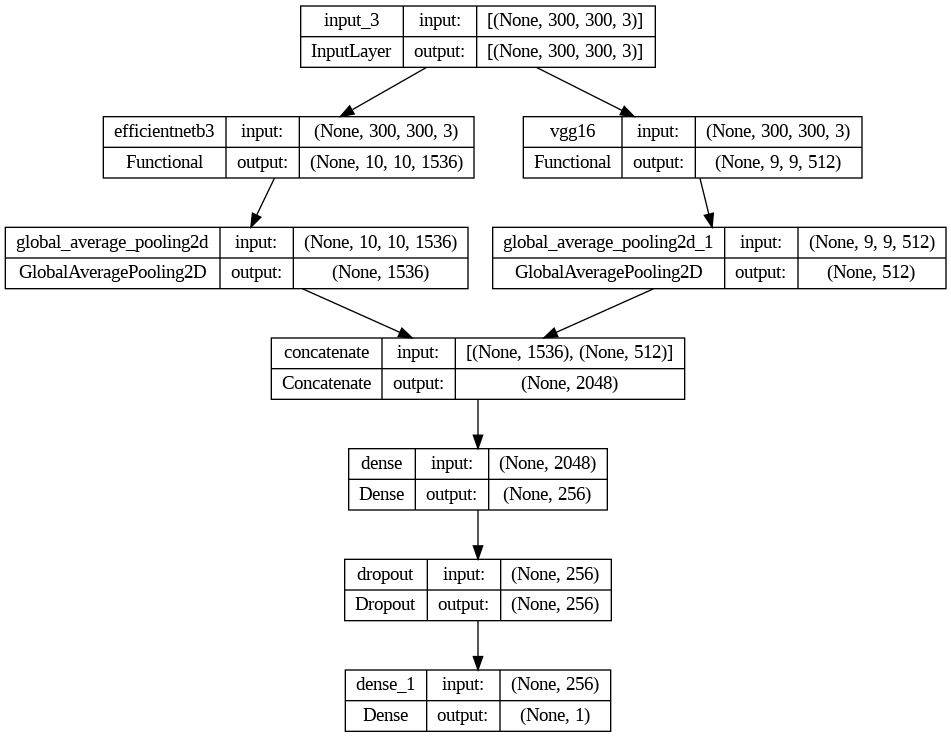

In [26]:
plot_model(ensemble3, to_file='ensemble_model.png', show_shapes=True, show_layer_names=True)

## Training & Validation Accuracy

In [32]:
print("Training Accuracy -", round(history.history['accuracy'][-1]*100,2),"%")
print("Validation Accuracy -", round(history.history['val_accuracy'][-1]*100,2),"%")

Training Accuracy - 81.97 %
Validation Accuracy - 86.0 %


## Plotting the Model History

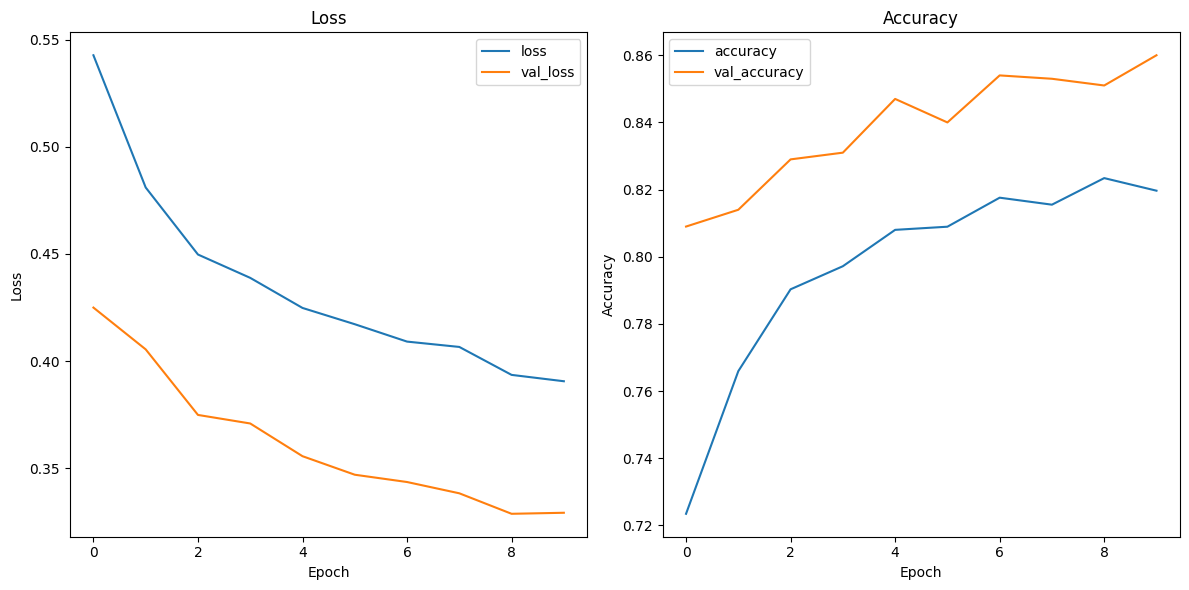

In [24]:
import matplotlib.pyplot as plt

def plotting(history):
    plot_data = pd.DataFrame(history.history)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plotting Loss
    plot_data[['loss', 'val_loss']].plot(ax=axes[0], title='Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    # Plotting Accuracy
    plot_data[['accuracy', 'val_accuracy']].plot(ax=axes[1], title='Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

plotting(history)

## Testing Model

In [37]:
from tensorflow.keras.preprocessing import image

def prediction(img_path):
  img = image.load_img(img_path, target_size=(300, 300))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0  # Normalize the pixel values

  # Make the prediction
  prediction = ensemble3.predict(img_array)

  # Convert the prediction to a class label
  predicted_class = print("Malignant")if prediction[0, 0] > 0.5 else print('Benign')

  # predicted_class
  print(prediction[0]*100)
  benign_sample = imread(img_path)
  plt.imshow(benign_sample)

### Benign testing

1/1 [==============================] - 0s 29ms/step
Benign
[32.49372]


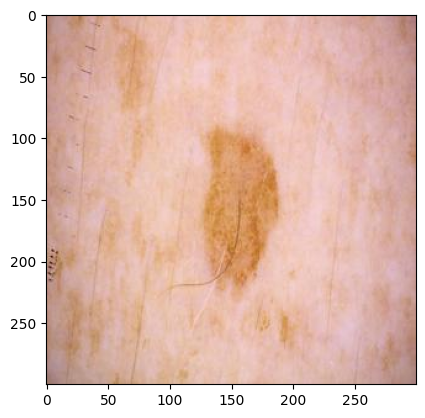

In [36]:
img_path = '/content/melanoma_cancer_dataset/test/benign/melanoma_10001.jpg'
prediction(img_path)

### Malignant testing

1/1 [==============================] - 0s 50ms/step
Malignant
[97.248184]


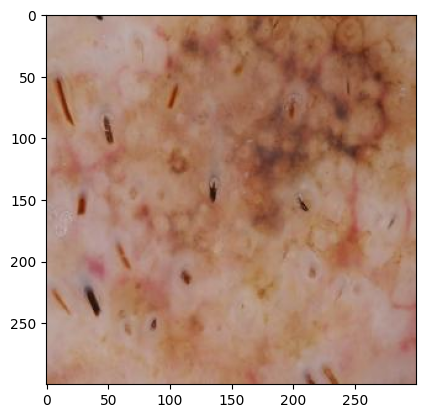

In [39]:
img_path= '/content/melanoma_cancer_dataset/test/malignant/melanoma_10113.jpg'
prediction(img_path)